In [1]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')
cvxopt.solvers.options['show_progress'] = False

In [2]:
#three common kernels for SVM: linear, polynomial, RBF
class Kernel:
    
    def linear():
        """
        Returns function that takes two vectors as a parameters and returns their dot product
        """
        return lambda x, y: np.dot(x, y)

        
    def polynomial(coef, power):
        """
        Returns function that takes two vectors as a parameters and computes polynomial kernel
        """
        return lambda x, y: np.power((np.dot(x, y) + coef), power)

        
    def rbf(gamma):
        """
        Returns function that takes two vectors as a parameters and computes rbf kernel
        """
        def _calc_rbf(x, y):
            if x.shape == y.shape:
                return np.exp(-gamma * np.linalg.norm(x - y) ** 2)
            
            n_samples = x.shape[0]
            n_sup_vecs = y.shape[1]
            result = np.zeros((n_samples, n_sup_vecs))
            for i in range(n_samples):
                for j in range(n_sup_vecs):
                    result[i, j] = np.exp(-gamma * np.linalg.norm(x[i] - y.T[j])**2)
            return result
        
        return _calc_rbf

In [3]:
class SVM:

    def __init__(self, C=1.0, kernel=Kernel.linear()):
        self.C = C
        self.kernel = kernel
        self.non_zero_multipliers = None
        self.support_vectors = None
        self.support_labels = None
        self.b = None
    
    
    def _kernel_matrix(self, X):
        """
        Computes kernel matrix applying kernel function pairwise for each sample
        X.shape: (number of features, number of samples)
        """
        n_samples = X.shape[1]
        
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[:, i], X[:, j])

        return K

        
    def _compute_lagrange_multipliers(self, X, Y):
        """
        Solves the quadratic optimization problem and calculates lagrange multipliers
        X.shape: (number of features, number of samples)
        Y.shape: (1, number of samples)
        """
        n_samples = X.shape[1]
        
        K = self._kernel_matrix(X)
        P = cvxopt.matrix(Y.T * Y * K * 1.)
        q = cvxopt.matrix(-np.ones((n_samples, 1)))

        if not self.C:
            G = cvxopt.matrix(-np.eye(n_samples))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G_max = np.identity(n_samples) * -1
            G_min = np.identity(n_samples)
            
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            
            h_max = np.zeros((n_samples, 1))
            h_min = np.ones((n_samples, 1)) * self.C
            
            h = cvxopt.matrix(np.vstack((h_max, h_min)))
        
        A = cvxopt.matrix(Y)
        b = cvxopt.matrix(np.zeros(1))

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        lagrange_multipliers = np.ravel(solution['x'])

        return lagrange_multipliers
    

    def _get_support_vectors(self, lagrange_multipliers, X, Y):
        """
        Extracts the samples that will act as support vectors and corresponding labels
        X.shape: (number of features, number of samples)
        Y.shape: (1, number of samples)
        """
        idx = (lagrange_multipliers > 1e-8)       
        non_zero_multipliers = lagrange_multipliers[idx]
        support_vectors = X[:, idx]
        support_labels = Y[:, idx]
 
        return non_zero_multipliers, support_vectors, support_labels

        
    def fit(self, X, Y):
        """
        Main training function
        X.shape: (number of features, number of samples)
        Y.shape: (1, number of samples)
        """
        lagrange_multipliers = self._compute_lagrange_multipliers(X, Y)

        self.non_zero_multipliers, self.support_vectors, self.support_labels = self._get_support_vectors(
                                                                                        lagrange_multipliers, X, Y) 

        self.b = self.support_labels[:, 0] - np.sum(self.non_zero_multipliers * self.support_labels * 
                                                    self.kernel(self.support_vectors[:, 0].T, self.support_vectors))
       
    
    def predict(self, X):
        """
        Predict function
        X.shape (number of features, number of samples)
        """
        n_samples = X.shape[1]
        predictions = np.sign(self.b + np.sum(self.non_zero_multipliers * self.support_labels * 
                                              self.kernel(X.T, self.support_vectors), axis=1))
        
        return predictions

In [4]:
#generate data
np.random.seed(17)
X_train = np.random.normal(size=300).reshape(150, 2)
y_train = (2 * (X_train.sum(axis=1) > 0) - 1.0).reshape(150, 1)

In [5]:
#explore class distribution
np.unique(y_train, return_counts=True)

(array([-1.,  1.]), array([76, 74]))

In [6]:
#function to print accuracy and plot learned decision boundary
def decision_boundary(model, data, target, grid_size=0.01):
    model.fit(data.T, target.T)
    y_pred = model.predict(data.T)
    print(f'Accuracy score: {accuracy_score(target, y_pred.T)}')
    
    x1_min, x1_max = data[:,0].min() - 1, data[:,0].max() + 1
    x2_min, x2_max = data[:,1].min() - 1, data[:,1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, grid_size), 
                           np.arange(x2_min, x2_max, grid_size), indexing='ij')
    
    z = model.predict(np.c_[xx1.ravel(), xx2.ravel()].T).reshape(xx1.shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(xx1, xx2, z, cmap='magma')
    sns.scatterplot(data[:, 0], data[:, 1], hue=target.ravel(), style=target.ravel(), palette='winter', 
                                                    alpha=.8, size=1, sizes=(100, 200))
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.xlabel('Feature1')
    plt.ylabel('Feature2')
    plt.title('Decision Boundary')
    plt.tight_layout()

Accuracy score: 0.98


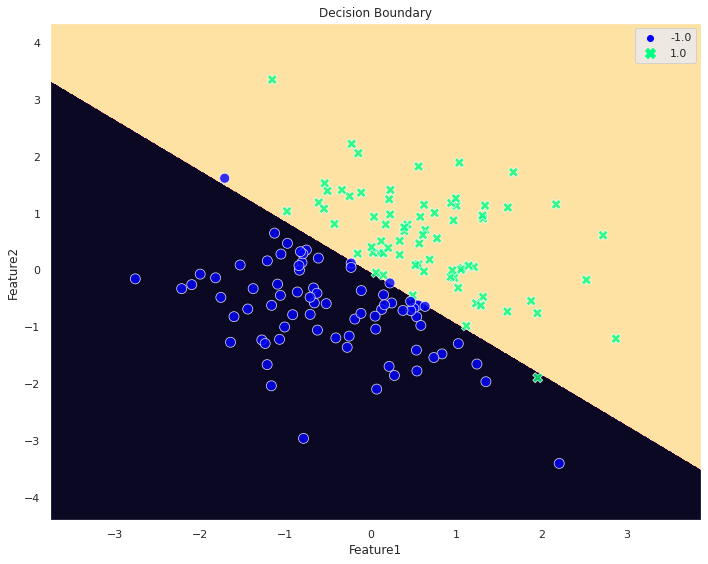

In [7]:
#SVM with C=1.0 and kernel=linear
clf = SVM()
decision_boundary(clf, X_train, y_train)

Accuracy score: 0.9933333333333333


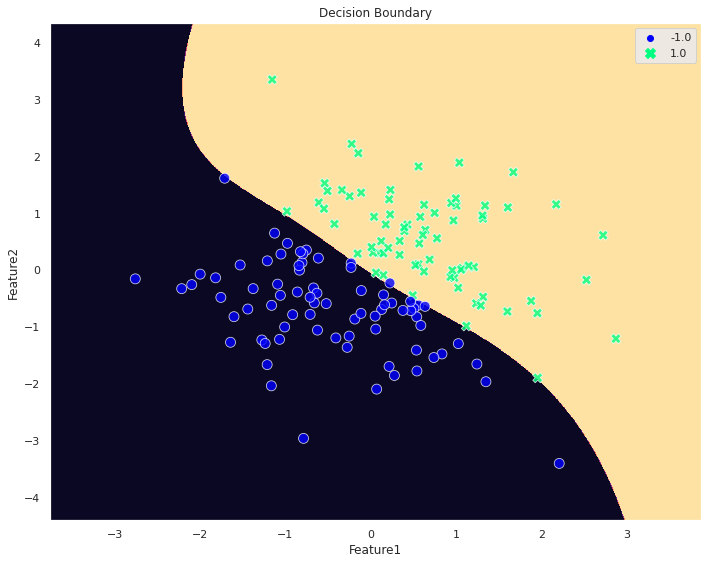

In [8]:
#SVM with C=1.0 and kernel=polynomial
clf = SVM(kernel=Kernel.polynomial(3, 5))
decision_boundary(clf, X_train, y_train)

Accuracy score: 0.9533333333333334


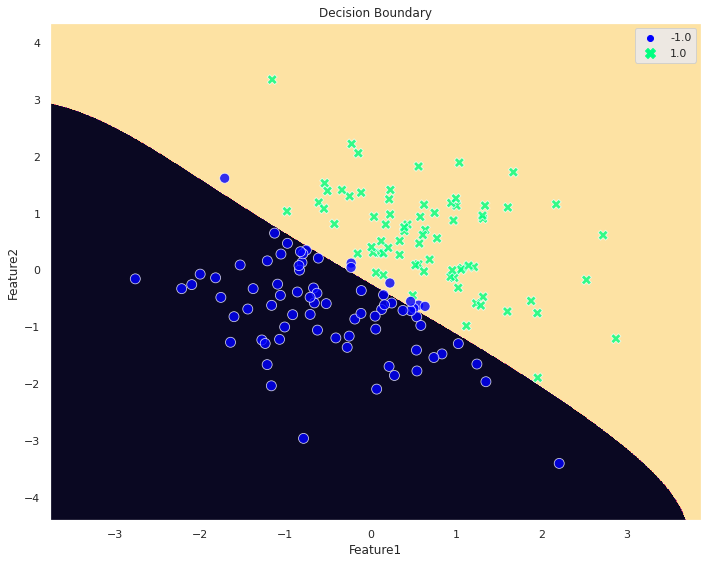

In [9]:
#SVM with C=1.0 and kernel=rbf
clf = SVM(kernel=Kernel.rbf(0.1))
decision_boundary(clf, X_train, y_train)